#  Metric analyses and figure preparation 

In the scope of the study we presented performances of predictor and dissected this performances by using metrics. These amino acid change related metrics are:

- Volume change,
- Hydrophobicity change,
- Flexibility change, and
- Physicochemical property change.


In [1]:
import pathlib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#import numpy as np
rootdir = pathlib.Path('.').resolve(strict=True)
outputdir = rootdir.parents [1] / 'files/output_files'

In [2]:
# import SARS_CoV_2_RBD_ACE2_benchmarking_dataset.csv
SARS_CoV_2_RBD_ACE2_benchmarking_dataset = pd.read_csv(outputdir / 'SARS-CoV-2-RBD_ACE2_benchmarking_dataset.csv', delimiter=',')

### Prediction status

Experimental energy where bigger than zero represents binding enhancing mutations, and less than zero represents binding decreasing mutations. According to that we classified mutations as enriched and depleted, respectively. On the other hand if predicted binding score of predictors are less than zero, it represents favorable binding means that enhancing binding. We used this description to determined the prediction status of predictors (success of failure) for a certain mutation by comparing predicted score to experimental binding energy.

In [3]:
pd.set_option('mode.chained_assignment', None)
def prediction_status(df):
    columns=df.columns
    ddg_columns=columns[columns.str.contains('ddg')]

    for i in ddg_columns:
        enriched = df[df['exp_binding']>0]
        depleted = df[df['exp_binding']<0]

        condition_enr = [
                (enriched.loc[:, [f'{i}']] < 0),
                (enriched.loc[:, [f'{i}']] >= 0)]

        value_enr = ['success', 'failure']
        enriched.loc[:,[f'{i}-prediction']] = np.select(condition_enr, value_enr)

        condition_dep = [
                (depleted.loc[:, [f'{i}']] <= 0),
                (depleted.loc[:, [f'{i}']] > 0)]

        value_dep = ['failure', 'success']
        depleted.loc[:,[f'{i}-prediction']] = np.select(condition_dep, value_dep)
        df=pd.concat([enriched, depleted])
    return (df)


### Volume Change 

This function concatenates vdW volume change of mutations as a column to corresponding dataset. 
Note that there should be '#case_id' column: [wild-type residue][position][mutated residue], A111C

In [4]:
def volume_change(df):
    volume = dict(A=0.05702, R=0.58946, N=0.22972, D=0.21051, C=0.14907, Q=0.34861, E=0.32837, G=0.00279, H=0.37694, I=0.37671,
              L=0.37876, K=0.45363, M=0.38872, F=0.55298, P=0.2279, S=0.09204, T=0.19341, W=0.79351, Y=0.6115, V=0.25674)
    
    list_caseid = df[['#case_id']].values.tolist()

    volume_change = []
    for i in list_caseid:
        mutant_resi= i[0][-1]
        wt_resi= i[0][0]
        #volume dictionary contains vdW volume of amino acids
        vdW_mutant_resi =volume[mutant_resi]
        vdW_wt_resi=volume[wt_resi]
        #2 place after the decimal
        delta_vdW=round(vdW_mutant_resi-vdW_wt_resi,2)
        volume_change.append(delta_vdW)

    volume_change_column=pd.DataFrame(volume_change, columns=['volume_change'])
    df = pd.concat([df,volume_change_column], axis=1)
    return(df)


### Hydrophobicity change

This function concatenates hydrophobicity change of mutations as a column to corresponding dataset. Note that there should be '#case_id' column: [WT residue][position][mutated residue], A111C

In [5]:
def hydrophobicity_change(df):
    hydrophobicity = dict(A=0.62, R=-2.53, N=-0.78, D=-0.90, C=0.29, Q=-0.85, E=-0.74, G=0.48, H=-0.40, I=1.38,
                L=1.06, K=-1.50, M=0.64, F=1.19, P=0.12, S=-0.18, T=-0.05, W=0.81, Y=0.26, V=1.08) 

    list_caseid = df[['#case_id']].values.tolist()

    hydrophobicity_change = []
    for i in list_caseid:
        mutant_resi= i[0][-1]
        wt_resi= i[0][0]
        #hydrophobicity dictionary contains hydrophobicity value of amino acids
        hyd_mutant_resi =hydrophobicity[mutant_resi]
        hyd_wt_resi=hydrophobicity[wt_resi]
        #2 place after the decimal
        delta_hyd=round(hyd_mutant_resi-hyd_wt_resi,2)
        hydrophobicity_change.append(delta_hyd)
   
    hydrophobicity_change_column=pd.DataFrame(hydrophobicity_change, columns=['hydrophobicity_change'])
    df = pd.concat([df,hydrophobicity_change_column], axis=1)
    return(df)


### Flexibility Change

This function concatenates flexibility change of mutations as a column to corresponding dataset. Note that there should be '#case_id' column: [WT residue][position][mutated residue], A111C


In [6]:
def flexibility_change(df):
    flexibility = dict(A=1, R=81, N=3, D=3, C=3, Q=9, E=9, G=1, H=3, I=9,
                L=9, K=81, M=27, F=3, P=2, S=3, T=3, W=3, Y=3, V=3) 

    list_caseid = df[['#case_id']].values.tolist()

    flexibility_change = []
    for i in list_caseid:
        mutant_resi= i[0][-1]
        wt_resi= i[0][0]
        #flexibility dictionary contains hydrophobicity value of amino acids
        flex_mutant_resi =flexibility[mutant_resi]
        flex_wt_resi=flexibility[wt_resi]
        #2 place after the decimal
        delta_flex=round(flex_mutant_resi-flex_wt_resi,2)
        flexibility_change.append(delta_flex)
   
    flexibility_change_column=pd.DataFrame(flexibility_change, columns=['flexibility_change'])
    df = pd.concat([df,flexibility_change_column], axis=1)
    return(df)


### Physicochemical Property Change

For this metric, first we classified amino acids as 
- non-polar, 
- polar, and 
- charge.

Then we defined the changing between this classes as

- no change,
- polarity gain,
- polarity loss,
- chage gain, and
- charge loss.
 

In [7]:
def physicochemical_property_change(df):
    physicochemical_property = dict(A='non-polar', R='charge', N='polar', D='charge', C='non-polar', Q='polar',
                                    E='charge', G='non-polar', H='charge', I='non-polar', L='non-polar', K='charge',
                                    M='non-polar', F='non-polar', P='non-polar', S='polar', T='polar', W='non-polar',
                                    Y='polar', V='non-polar') 

    list_caseid = df[['#case_id']].values.tolist()

    wt = []
    mutant = []
    for i in list_caseid:
        mutant_resi= i[0][-1]
        wt_resi= i[0][0]
        #physicochemical_property dictionary contains physicochemical property of amino acids
        mutant_property =physicochemical_property[mutant_resi]
        wt_property=physicochemical_property[wt_resi] 

        mutant.append(mutant_property)
        wt.append(wt_property)

    mutant_dataframe=pd.DataFrame(mutant, columns=['mutant_property'])
    wt_dataframe=pd.DataFrame(wt, columns=['wt_property'])

    df = pd.concat([df, wt_dataframe, mutant_dataframe], axis=1)
    
    # for 3 kind of wild-type property will change
   
    #non-polar wt
    nonpolar = df[df['wt_property'] == "non-polar" ]
    condition1 = [
                (nonpolar.loc[:, ['mutant_property']] == 'non-polar'),
                (nonpolar.loc[:, ['mutant_property']] == 'polar'),
                (nonpolar.loc[:, ['mutant_property']] == 'charge')]
    value1 = ['no_change', 'polarity_gain', 'charge_gain']
    nonpolar.loc[:,['physicochem_property_change']] = np.select(condition1, value1)
    
    #polar wt
    polar = df[df['wt_property'] == "polar" ]
    condition2 = [
                (polar.loc[:, ['mutant_property']] == 'non-polar'),
                (polar.loc[:, ['mutant_property']] == 'polar'),
                (polar.loc[:, ['mutant_property']] == 'charge')]
    value2 = ['polarity_loss', 'no_change', 'charge_gain']
    polar.loc[:,['physicochem_property_change']] = np.select(condition2, value2)
    
    #charge wt
    charge = df[df['wt_property'] == "charge" ]
    condition3 = [
                (charge.loc[:, ['mutant_property']] == 'non-polar'),
                (charge.loc[:, ['mutant_property']] == 'polar'),
                (charge.loc[:, ['mutant_property']] == 'charge')]
    value3 = ['charge_loss', 'charge_loss', 'no_change']
    charge.loc[:,['physicochem_property_change']] = np.select(condition3, value3)
    
    df = pd.concat([nonpolar, polar, charge], axis=0)

    df.drop(['mutant_property', 'wt_property'], inplace=True, axis=1)
    return(df)


### Adding metric and prediction status columns by using defined functions

In [8]:
main_dataset = prediction_status(physicochemical_property_change(flexibility_change(hydrophobicity_change(volume_change(SARS_CoV_2_RBD_ACE2_benchmarking_dataset)))))

## Plots of volume, hydrophobicity and flexibility change metrics

In [9]:
def vol_hyd_flex_fig_dataset(df, prediction_status):
    predictors_data = []
    predictor_list=['haddock', 'foldx', 'foldxwater', 'evoef1', 'mutabind2', 'ssipe']
    for i in predictor_list:        
        predictor= df[df[f'{i}-ddg-prediction'].str.contains(prediction_status)]
        predictor=predictor.copy()
        predictor['predictor']=i.upper()
        predictors_data.append(predictor)        
    experimental = df.copy()
    experimental['predictor'] = "Experimental"
        
    dataset = pd.concat([predictors_data[0], predictors_data[1], predictors_data[2], predictors_data[3], predictors_data[4], predictors_data[5], experimental], axis=0)
    return(dataset)
# define enriched and depleted dataset
enriched = main_dataset[main_dataset.exp_binding >0 ]
depleted = main_dataset[main_dataset.exp_binding <0 ]

# datasets for plot preperation
Enriched_Success_dataset = vol_hyd_flex_fig_dataset(enriched, prediction_status = "success").sort_values("predictor")
Enriched_Failure_dataset = vol_hyd_flex_fig_dataset(enriched, prediction_status = "failure").sort_values("predictor")
Depleted_Success_dataset = vol_hyd_flex_fig_dataset(depleted, prediction_status = "success").sort_values("predictor")
Depleted_Failure_dataset = vol_hyd_flex_fig_dataset(depleted, prediction_status = "failure").sort_values("predictor")

Text(0.5, 1.0, 'Depleted Failure')

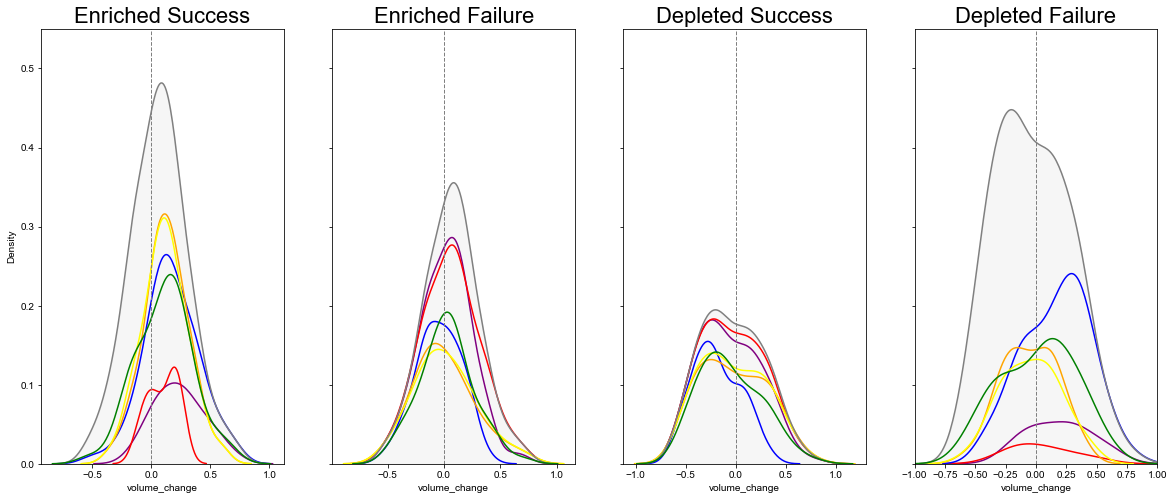

In [10]:
def kdeplot(df,quantity,limit_y,limit_x, subplot):
    sns.set_style('white')
    color=["green", "gray", "yellow","orange", "blue", "red", "purple"]
    g = sns.kdeplot(data=df, x=quantity, hue="predictor",palette=color, legend=False, ax=subplot)
    x = g.lines[-2].get_xdata()
    y = g.lines[-2].get_ydata()
    g.fill_between(x, 0, y, color='gray', alpha=0.07)
    g.axvline(0, color = 'gray', linestyle = 'dashed', linewidth = 1)
    plt.ylim(limit_y)
    plt.xlim(limit_x)

fig1,axes=plt.subplots(1,4, sharey=True, figsize=(20,8))
# Volume
kdeplot(Enriched_Success_dataset, quantity ='volume_change',limit_y=(0,0.55), limit_x=(-1,1), subplot=axes[0])
kdeplot(Enriched_Failure_dataset, quantity ='volume_change',limit_y=(0,0.55), limit_x=(-1,1), subplot=axes[1])
kdeplot(Depleted_Success_dataset, quantity ='volume_change',limit_y=(0,0.55), limit_x=(-1,1), subplot=axes[2])
kdeplot(Depleted_Failure_dataset, quantity ='volume_change',limit_y=(0,0.55), limit_x=(-1,1), subplot=axes[3])

axes[0].set_title('Enriched Success', size=22)
axes[1].set_title('Enriched Failure', size=22)
axes[2].set_title('Depleted Success', size=22)
axes[3].set_title('Depleted Failure', size=22)

Text(0.5, 1.0, 'Depleted Failure')

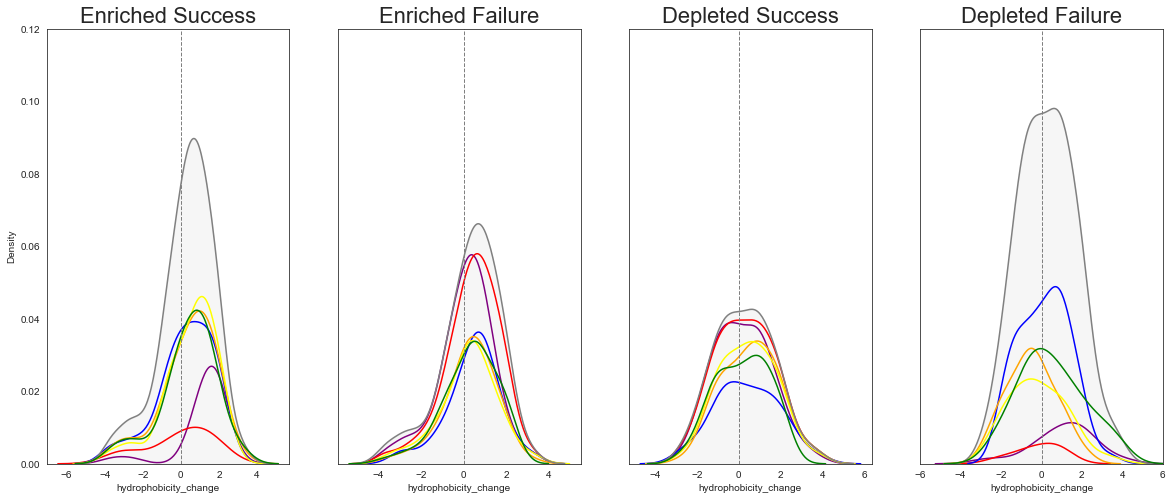

In [11]:
fig2,axes=plt.subplots(1,4, sharey=True,  figsize=(20,8))
# Hydrophobicity
kdeplot(Enriched_Success_dataset, quantity ='hydrophobicity_change',limit_y=(0,0.12), limit_x=(-6,6), subplot=axes[0])
kdeplot(Enriched_Failure_dataset, quantity ='hydrophobicity_change',limit_y=(0,0.12), limit_x=(-6,6), subplot=axes[1])
kdeplot(Depleted_Success_dataset, quantity ='hydrophobicity_change',limit_y=(0,0.12), limit_x=(-6,6), subplot=axes[2])
kdeplot(Depleted_Failure_dataset, quantity ='hydrophobicity_change',limit_y=(0,0.12), limit_x=(-6,6), subplot=axes[3])

axes[0].set_title('Enriched Success', size=22)
axes[1].set_title('Enriched Failure', size=22)
axes[2].set_title('Depleted Success', size=22)
axes[3].set_title('Depleted Failure', size=22)

Text(0.5, 1.0, 'Depleted Failure')

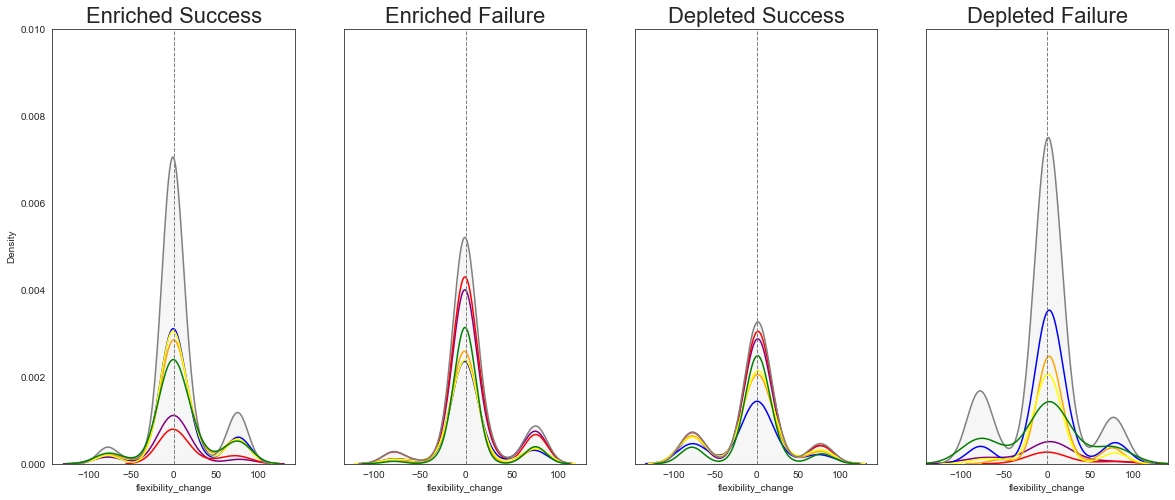

In [12]:
fig3,axes=plt.subplots(1,4, sharey=True,  figsize=(20,8))
# Flexibity
kdeplot(Enriched_Success_dataset, quantity ='flexibility_change',limit_y=(0,0.01), limit_x=(-140,140), subplot=axes[0])
kdeplot(Enriched_Failure_dataset, quantity ='flexibility_change',limit_y=(0,0.01), limit_x=(-140,140), subplot=axes[1])
kdeplot(Depleted_Success_dataset, quantity ='flexibility_change',limit_y=(0,0.01), limit_x=(-140,140), subplot=axes[2])
kdeplot(Depleted_Failure_dataset, quantity ='flexibility_change',limit_y=(0,0.01), limit_x=(-140,140), subplot=axes[3])

axes[0].set_title('Enriched Success', size=22)
axes[1].set_title('Enriched Failure', size=22)
axes[2].set_title('Depleted Success', size=22)
axes[3].set_title('Depleted Failure', size=22)

## ∆Success Rate Table

In [86]:
metrics = ['volume_change', 'hydrophobicity_change', 'flexibility_change']
predictors = ['HADDOCK', 'FOLDX', 'FOLDXWATER', 'EVOEF1', 'MUTABIND2', 'SSIPE']
success_rates = []
table = []
for i in metrics:
    Enriched_Success_dataset_bigger_than_0 = Enriched_Success_dataset[Enriched_Success_dataset[i] >= 0]
    Depleted_Success_dataset_bigger_than_0 = Depleted_Success_dataset[Depleted_Success_dataset[i] >= 0]
    for i in predictors:
        enr=round(len(Enriched_Success_dataset_bigger_than_0[Enriched_Success_dataset_bigger_than_0['predictor']==f'{i}'])/len(Enriched_Success_dataset_bigger_than_0[Enriched_Success_dataset_bigger_than_0['predictor']=="Experimental"])*100, 0)
        dep=round(len(Depleted_Success_dataset_bigger_than_0[Depleted_Success_dataset_bigger_than_0['predictor']==f'{i}'])/len(Depleted_Success_dataset_bigger_than_0[Depleted_Success_dataset_bigger_than_0['predictor']=="Experimental"])*100, 0)
        success_rates.append([enr, dep, enr-dep])

x = pd.DataFrame(success_rates, columns=['Enriched success', "Depleted success","∆Success rate"], index=['HADDOCK', 'FoldX', 'FoldXwater', 'EvoEF1','MutaBind2', 'SSIPe', 'HADDOCK', 'FoldX', 'FoldXwater', 'EvoEF1','MutaBind2', 'SSIPe', 'HADDOCK', 'FoldX', 'FoldXwater', 'EvoEF1','MutaBind2', 'SSIPe'])
Volume = x[0:6]
Hydrophobicity = x[6:12]
Flexibility = x[12:18]

x = pd.concat([Volume, Hydrophobicity, Flexibility],keys=["Volume", "Hydrophobicity", "Flexibility"])
x = x.style.format('{:.0f}')
x.set_table_styles([{'selector' : '','props' : [('border','1px solid black')]}])
cm = sns.diverging_palette(220, 20, as_cmap=True)
table = x.background_gradient(cmap=cm, subset=["∆Success rate"], axis=None, vmin=-100, vmax=100 )
table = table.set_properties(**{'font-size': '13pt', 'font-family': 'Helvatica'})
table

## Plots of physicochemical property change metric

In [ ]:
def physicochemical_fig_dataset(df, prediction_status):
    haddock = df[df['haddock-ddg-prediction'].str.contains(prediction_status)]
    haddock_counts = haddock["physicochem_property_change"].value_counts()
    
    foldx = df[df['foldx-ddg-prediction'].str.contains(prediction_status)]
    foldx_counts = foldx["physicochem_property_change"].value_counts()

    foldxwater = df[df['foldxwater-ddg-prediction'].str.contains(prediction_status)]
    foldxwater_counts = foldxwater["physicochem_property_change"].value_counts()

    evoef1 = df[df['evoef1-ddg-prediction'].str.contains(prediction_status)]
    evoef1_counts = evoef1["physicochem_property_change"].value_counts()

    mutabind2 = df[df['mutabind2-ddg-prediction'].str.contains(prediction_status)]
    mutabind2_counts = mutabind2["physicochem_property_change"].value_counts()

    ssipe = df[df['ssipe-ddg-prediction'].str.contains(prediction_status)]
    ssipe_counts = ssipe["physicochem_property_change"].value_counts()
    counts=[haddock_counts, foldx_counts, foldxwater_counts, evoef1_counts, mutabind2_counts, ssipe_counts]
    df = pd.concat(counts, axis=1, keys=['HADDOCK', 'FoldX', 'FoldXwater', 'EvoEF1', 'MutaBind2', 'SSIPe']).replace(np.nan, 0)
    return(df)
 
#enriched and depleted datasets 
enriched = main_dataset[main_dataset.exp_binding >0 ]
depleted = main_dataset[main_dataset.exp_binding <0 ]

#Gray bars for dataset description, lights are enriched
experimental_enriched_counts = enriched["physicochem_property_change"].value_counts()
experimental_enriched = round(experimental_enriched_counts/263*100,2)
experimental_enriched = pd.DataFrame(experimental_enriched) 
experimental_enriched = experimental_enriched.T
#Gray bars for dataset description, darks are depleted
experimental_depleted_counts = depleted["physicochem_property_change"].value_counts()
experimental_depleted = round(experimental_depleted_counts/263*100,2)
experimental_depleted = pd.DataFrame(experimental_depleted) 
experimental_depleted = experimental_depleted.T
# Light bars for predictors
physicochemical_fig_enriched = physicochemical_fig_dataset(enriched, prediction_status="success")
enriched_ratio = round(physicochemical_fig_enriched/263*100,2)
enriched_ratio = enriched_ratio.T
# Dark bars for predictors
physicochemical_fig_depleted = physicochemical_fig_dataset(depleted, prediction_status="success")
depleted_ratio = round(physicochemical_fig_depleted/263*100,2)
depleted_ratio = depleted_ratio.T


In [ ]:
mpl.style.use('seaborn-white')

# predictors and colors of datasets
colors_depleted = ['blue', "yellow", "orange", "green", "red", "purple" ]
colors_enriched = ['skyblue', "lemonchiffon" ,"moccasin", "lightgreen", "lightcoral", "plum" ]
labels = ['HADDOCK', 'FoldX', 'FoldXwater','EvoEF1', 'MutaBind2', 'SSIPe']
labels_exp='Experimental'
mpl.rcParams.update({'font.size': 20})

fig4, axs = plt.subplots(2, 5, figsize=(20,8), gridspec_kw={'height_ratios': [2, 0.3]})

axs[0, 0].set_title('No change', size=22)
axs[0, 1].set_title('Polarity loss', size=22)
axs[0, 2].set_title('Charge loss', size=22)
axs[0, 3].set_title('Charge gain ', size=22)
axs[0, 4].set_title('Polarity gain', size=22)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)

# experimental
axs[1, 0].barh(labels_exp, experimental_depleted["no_change"], label='Depleted', color="gray")
axs[1, 0].barh(labels_exp, experimental_enriched["no_change"], label='Enriched', left=experimental_depleted["no_change"], color="lightgray")
nochange_xlim=int(experimental_enriched["no_change"][0] + experimental_depleted["no_change"][0])
axs[1, 0].set_xlim([0, nochange_xlim])
axs[1, 0].xaxis.set_ticks(np.arange(0, nochange_xlim, 5))
axs[1, 0].set(yticklabels=["Exp. dataset"])

axs[1, 1].barh(labels_exp, experimental_depleted["polarity_loss"], label='Depleted', color="gray")
axs[1, 1].barh(labels_exp, experimental_enriched["polarity_loss"], label='Enriched', left=experimental_depleted["polarity_loss"], color="lightgray")
polarityloss_xlim=int(experimental_enriched["polarity_loss"][0] + experimental_depleted["polarity_loss"][0])
axs[1, 1].set_xlim([0, polarityloss_xlim])
axs[1, 1].set(yticklabels=[])
axs[1, 1].xaxis.set_ticks(np.arange(0, polarityloss_xlim, 5))


axs[1, 2].barh(labels_exp, experimental_depleted["charge_loss"], label='Depleted', color="gray")
axs[1, 2].barh(labels_exp, experimental_enriched["charge_loss"], label='Enriched', left=experimental_depleted["charge_loss"], color="lightgray")
chargeloss_xlim=int(experimental_enriched["charge_loss"][0] + experimental_depleted["charge_loss"][0])
axs[1, 2].set_xlim([0, chargeloss_xlim])
axs[1, 2].set(yticklabels=[])
axs[1, 2].xaxis.set_ticks(np.arange(0, chargeloss_xlim, 5))

axs[1, 3].barh(labels_exp, experimental_depleted["charge_gain"], label='Depleted', color="gray")
axs[1, 3].barh(labels_exp, experimental_enriched["charge_gain"], label='Enriched', left=experimental_depleted["charge_gain"], color="lightgray")
chargegain_xlim=int(experimental_enriched["charge_gain"][0] + experimental_depleted["charge_gain"][0])
axs[1, 3].set_xlim([0, chargegain_xlim])
axs[1, 3].set(yticklabels=[])
axs[1, 3].xaxis.set_ticks(np.arange(0, chargegain_xlim, 5))

axs[1, 4].barh(labels_exp, experimental_depleted["polarity_gain"], label='Depleted', color="gray")
axs[1, 4].barh(labels_exp, experimental_enriched["polarity_gain"], label='Enriched', left=experimental_depleted["polarity_gain"], color="lightgray")
polaritygain_xlim=int(experimental_enriched["polarity_gain"][0] + experimental_depleted["polarity_gain"][0])
axs[1, 4].set_xlim([0, polaritygain_xlim])
axs[1, 4].set(yticklabels=[])
axs[1, 4].xaxis.set_ticks(np.arange(0, polaritygain_xlim, 5))


#no change
axs[0, 0].barh(labels, depleted_ratio["no_change"], label='Depleted', color=colors_depleted)
axs[0, 0].barh(labels, enriched_ratio["no_change"], label='Enriched', left=depleted_ratio["no_change"], color=colors_enriched)
axs[0, 0].set_xlim([0, nochange_xlim])
axs[0, 0].set(xticklabels=[])

#polarity_loss
axs[0, 1].barh(labels, depleted_ratio["polarity_loss"], label='Depleted', color=colors_depleted)
axs[0, 1].barh(labels, enriched_ratio["polarity_loss"], label='Enriched', left=depleted_ratio["polarity_loss"], color=colors_enriched)
axs[0, 1].set_xlim([0, polarityloss_xlim])
axs[0, 1].set(yticklabels=[])
axs[0, 1].set(xticklabels=[])

#charge_gain
axs[0, 2].barh(labels, depleted_ratio["charge_loss"], label='Depleted', color=colors_depleted,)
axs[0, 2].barh(labels, enriched_ratio["charge_loss"], label='Enriched', left=depleted_ratio["charge_loss"], color=colors_enriched)
axs[0, 2].set_xlim([0, chargeloss_xlim])
axs[0, 2].set(yticklabels=[])
axs[0, 2].set(xticklabels=[])

#charge_gain
axs[0, 3].barh(labels, depleted_ratio["charge_gain"], label='Depleted', color=colors_depleted,)
axs[0, 3].barh(labels, enriched_ratio["charge_gain"], label='Enriched', left=depleted_ratio["charge_gain"], color=colors_enriched)
axs[0, 3].set_xlim([0, chargegain_xlim])
axs[0, 3].set(yticklabels=[])
axs[0, 3].set(xticklabels=[])

#polarity_gain
axs[0, 4].barh(labels, depleted_ratio["polarity_gain"], label='Depleted', color=colors_depleted,)
axs[0, 4].barh(labels, enriched_ratio["polarity_gain"], label='Enriched', left=depleted_ratio["polarity_gain"], color=colors_enriched)
axs[0, 4].set_xlim([0, polaritygain_xlim])
axs[0, 4].set(yticklabels=[])
axs[0, 4].set(xticklabels=[])

# legend
axs[1, 0].legend(['Dark colors represents depleted cases', 'Light colors represents enriched cases'], loc = 'lower center', bbox_to_anchor = (0, -1.8), fontsize=20)


In [ ]:
figures=[fig1,fig2,fig3,fig4]
with PdfPages(outputdir / 'Figures.pdf') as pdf:
    for i in figures:
        pdf.savefig(i)